# Practical Assignment: Greater Sydney Analysis

## Task 1 Import Datasets and Data Cleaning

### 1.1 Setting up the spatial data

In [ ]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import time
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from IPython.display import HTML
from sqlalchemy import text
from geoalchemy2 import Geometry
from shapely.geometry import Point, Polygon, MultiPolygon, shape


HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')
credentials = "Credentials.json"
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
db, conn = pgconnect(credentials)
conn.commit()


Connected successfully.


In [ ]:
income = pd.read_csv('Income.csv', na_values=['np'])
businesses = pd.read_csv('Businesses.csv')
population = pd.read_csv('Population.csv')
stops = pd.read_csv("Stops.txt",
                 dtype={
                   "stop_id": str,
                   "stop_code": str,
                   "stop_name": str,
                   "stop_lat": float,
                   "stop_lon": float,
                   "location_type": str,
                   "parent_station": str,
                   "wheelchair_boarding": str,
                   "platform_code": str
                 })
SA2_regions = gpd.read_file(
    "SA2_2021_AUST_SHP_GDA2020.zip"
)
future_catchments = gpd.read_file(
    "catchments_future.shp"
)
primary_catchments = gpd.read_file(
    "catchments_primary.shp"
)
secondary_catchments = gpd.read_file(
    "catchments_secondary.shp"
)
primary_catchments = primary_catchments.to_crs(future_catchments.crs)
secondary_catchments = secondary_catchments.to_crs(future_catchments.crs)

# concatenate
catchments = gpd.GeoDataFrame(
    pd.concat([future_catchments, primary_catchments, secondary_catchments], ignore_index=True),
    crs=future_catchments.crs
)
catchments.columns = catchments.columns.str.strip().str.lower()
catchments = catchments.drop_duplicates(subset=['use_id'], keep='first')

# clean unvalid spatial data
catchments['geometry'] = catchments['geometry'].buffer(0)
valid = catchments.geometry.is_valid
catchments = catchments[valid]
srid = 4283
catchments.columns = catchments.columns.str.lower()

# drop year1 through year12
years = [f'year{i}' for i in range(1, 13)]
catchments = catchments.drop(columns=years)
catchments = catchments.drop(columns="kindergart")

catchments = catchments.to_crs(epsg=srid)

conn.execute(text("DROP TABLE IF EXISTS catchments;"))

#  CREATE the catchments schema and call the to_sql to load into database
conn.execute(text(f"""
CREATE TABLE catchments (
    use_id       VARCHAR(10)    PRIMARY KEY,
    catch_type   VARCHAR(20),
    use_desc     VARCHAR(40),
    add_date     DATE,
    priority     VARCHAR(10),
    geometry     GEOMETRY(MULTIPOLYGON,4283)
);
"""))
conn.commit()

# Add spatial (GiST) indexes on the geometry columns
conn.execute(text("""
CREATE INDEX IF NOT EXISTS catchments_geom_index
  ON catchments
  USING GIST (geometry);
"""))
conn.commit()

from geoalchemy2 import Geometry, WKTElement
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

temp = pd.DataFrame(catchments.drop(columns="geometry"))

temp["geometry"] = catchments["geometry"].apply(
    lambda g: create_wkt_element(g, srid)
)
catchments = temp

catchments.to_sql('catchments', conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
conn.commit()

# Test
query(conn, '''select *
      from catchments
      limit 5''')

,use_id,catch_type,use_desc,add_date,priority,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,2023-01-14,None,0106000020BB1000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,2020-02-20,None,0106000020BB100000010000000103000000020000006C...
2,1498,PRIMARY,Brisbania PS,2021-11-15,None,0106000020BB100000010000000103000000010000001F...
3,1659,PRIMARY,Corowa SPS,2020-04-04,None,0106000020BB1000000100000001030000000100000007...
4,3867,PRIMARY,Lake Illawarra SPS,2022-06-19,None,0106000020BB1000000100000001030000000100000022...


In [119]:
srid = 4283
sa2_sydney = SA2_regions[SA2_regions["GCC_NAME21"] == "Greater Sydney"]
sa2_sydney = sa2_sydney.to_crs(epsg=srid)
sa2_sydney.columns = sa2_sydney.columns.str.lower()


conn.execute(text("DROP TABLE IF EXISTS sa2_sydney;"))

keep = ['sa2_code21', 'sa2_name21', 'sa4_name21', 'gcc_name21', 'geometry']
sa2_sydney =  sa2_sydney[keep]

# clean unvalid spatial data
sa2_sydney['geometry'] = sa2_sydney['geometry'].buffer(0)
valid = sa2_sydney.geometry.is_valid
sa2_sydney = sa2_sydney[valid]

#  CREATE the table for sa2_regions
conn.execute(text(f"""
CREATE TABLE sa2_sydney (
    sa2_code21    VARCHAR(21)      NOT NULL     PRIMARY KEY,        
    sa2_name21    VARCHAR(60)      NOT NULL,                            
    sa4_name21    VARCHAR(40),                                            
    gcc_name21    VARCHAR(20),                                         
    geometry      GEOMETRY(MULTIPOLYGON, 4283)    
);
"""))
conn.commit()

# Add spatial (GiST) indexes on the geometry columns

conn.execute(text("""
CREATE INDEX IF NOT EXISTS sa2_sydney_geom_index
  ON sa2_sydney
  USING GIST (geometry);
"""))
conn.commit()


sa2_sydney['geometry'] = sa2_sydney['geometry'].apply(
    lambda g: create_wkt_element(g, srid)
)

sa2_sydney.to_sql(
    name='sa2_sydney',
    con=conn,          
    if_exists='append',
    index=False, dtype={
        'geometry': Geometry('MULTIPOLYGON', srid=srid)
    }
)
conn.commit()


sa2_sydney.columns = sa2_sydney.columns.str.upper()

from geoalchemy2.shape import to_shape

sa2_sydney['GEOMETRY'] = sa2_sydney['GEOMETRY'].apply(to_shape)
catchments['geometry'] = catchments['geometry'].apply(to_shape)

# Test 
query(conn, "select * from sa2_sydney limit 5")


C:\Users\jacky\AppData\Local\Temp\ipykernel_26688\2564214026.py:39: UserWarning: Geometry column does not contain geometry.
  sa2_sydney['geometry'] = sa2_sydney['geometry'].apply(


,sa2_code21,sa2_name21,sa4_name21,gcc_name21,geometry
0,102011028,Avoca Beach - Copacabana,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,Central Coast,Greater Sydney,0106000020BB1000000200000001030000000100000059...
3,102011031,Erina - Green Point,Central Coast,Greater Sydney,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,Central Coast,Greater Sydney,0106000020BB100000010000000103000000010000007E...


### 1.2 Data cleaning and importing data to database

In [120]:
# For the income table, replace the missing data with the mean value of that column

cleaning = ['earners','median_age','median_income','mean_income']

income[cleaning] = income[cleaning].apply(pd.to_numeric, errors='coerce')
for col in cleaning:
    mean_val = int(income[col].mean(skipna=True))
    income[col] = income[col].fillna(mean_val).astype(int)

#Clean the stops data
stops['location_type'] = pd.to_numeric(stops['location_type'], errors = 'coerce')
stops['wheelchair_boarding'] = pd.to_numeric(stops['wheelchair_boarding'], errors = 'coerce')

# replace missing value (error) into 0 as the default value
stops.replace(
    {'location_type':          {np.nan: 0},
     'wheelchair_boarding':    {np.nan: 0}},
    inplace=True
)

# business 
businesses = businesses.loc[businesses['total_businesses'] > 0]

#population 
population = population.loc[population['total_people'] > 0]

In [121]:
from sqlalchemy import text, Integer, Float, Numeric, Text
import pandas as pd
import geopandas as gpd

# Drop the unused column for income table and load it into database
conn.execute(text("DROP TABLE IF EXISTS income;"))
conn.execute(text("""
CREATE TABLE income (
  sa2_code21    VARCHAR(21)   NOT NULL  PRIMARY KEY,
  sa2_name      VARCHAR(60)   NOT NULL,
  earners       INTEGER,
  median_age    INTEGER,
  median_income NUMERIC,
  mean_income   NUMERIC
);
"""))
conn.commit()

income.to_sql(
  'income',
  con=conn,
  if_exists='append',
  index=False
)
conn.commit()

In [122]:

# Drop the unused columns for business table and load it into database
drop_col = [
    '0_to_50k_businesses',
    '50k_to_200k_businesses',
    '200k_to_2m_businesses',
    '2m_to_5m_businesses',
    '5m_to_10m_businesses',
    '10m_or_more_businesses'
]

businesses = businesses.drop(columns=drop_col)

businesses['sa2_code']      = businesses['sa2_code'].astype(str)
businesses['industry_code'] = businesses['industry_code'].astype(str)

businesses['business_id'] = (
    businesses['sa2_code']
    + '_' 
    + businesses['industry_code']
)


conn.execute(text("DROP TABLE IF EXISTS businesses;"))
conn.execute(text("""
CREATE TABLE businesses (
  business_id        VARCHAR(30)    PRIMARY KEY,
  industry_code                VARCHAR(2),
  industry_name                VARCHAR(61),
  sa2_code                     VARCHAR(21),
  sa2_name                     VARCHAR(61),
  total_businesses             INTEGER
);
"""))
conn.commit()

businesses.to_sql(
  'businesses',
  con=conn,
  if_exists='append',
  index=False
)
conn.commit()


In [123]:

# Drop the unused columns for population table and load it into database

# Get the young population and drop those unnecessary columns
young_bands = ['0-4_people', '5-9_people', '10-14_people', '15-19_people']
population['young_pop'] = population[young_bands].sum(axis=1)
population = population[['sa2_code', 'sa2_name', 'young_pop', 'total_people']]

# Create the new schema for population and load it into database 
conn.execute(text("DROP TABLE IF EXISTS population;"))

conn.execute(text("""
CREATE TABLE population (
  sa2_code       VARCHAR(21)   NOT NULL   PRIMARY KEY,
  sa2_name       VARCHAR(61)   NOT NULL,
  young_pop      INTEGER       NOT NULL,
  total_people   INTEGER       NOT NULL
);
"""))
conn.commit()

population.to_sql(
  'population',
  con=conn,
  if_exists='append',
  index=False
)
conn.commit()



In [124]:

# Drop the unused columns for STOPS table and load it into database

drop_col = [
    'location_type',
    'parent_station',
    'wheelchair_boarding',
    'platform_code'
]

stops = stops.drop(columns=drop_col)

conn.execute(text("DROP TABLE IF EXISTS stops;"))
conn.execute(text("""
CREATE TABLE stops (
  stop_id             VARCHAR(21)   PRIMARY KEY,
  stop_code           VARCHAR(21),
  stop_name           VARCHAR(80),
  stop_lat            FLOAT,
  stop_lon            FLOAT

);
"""))
conn.commit()

# — no lowercasing step here —
stops.to_sql(
  'stops',
  con=conn,
  if_exists='append',
  index=False,
)
conn.commit()



In [125]:
# verify
for tbl in ('income','businesses','population','stops'):
    print(tbl, query(conn, f"SELECT COUNT(*) FROM {tbl}"))

income    count
0    642
businesses    count
0  11164
population    count
0    372
stops     count
0  114718


## Task 2 Form SA_2 datasets

### 2.1 Get POIs from the NSW Points of Interest API 

In [126]:
import requests
def get_pois_in_bbox(xmin, ymin, xmax, ymax):
    url = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'
    geometry = f'{xmin},{ymin},{xmax},{ymax}'
    params = {
        'geometry': geometry,
        'geometryType': 'esriGeometryEnvelope', 
        'spatialRel': 'esriSpatialRelIntersects', 
        'outFields': '*',
        'returnGeometry': 'true',
        'f': 'json'
    }

    response = requests.get(url, params=params)
    time.sleep(1)
    if response.status_code == 200:
        data = response.json().get('features', [])
        l = []
        for i in data:
            l.append(i['attributes'])
        return l

    else:
        print(f"Error {response.status_code}: {response.text}")
        return []
    

In [127]:
sa2_sutherland = sa2_sydney[sa2_sydney['SA4_NAME21'] == 'Sydney - Sutherland']
sa2_central_coast = sa2_sydney[sa2_sydney['SA4_NAME21'] == 'Central Coast']
sa2_ryde = sa2_sydney[sa2_sydney['SA4_NAME21'] == 'Sydney - Ryde']

In [128]:
#Type cast so that the sa2_code can be used to compare

population['sa2_code'] = population['sa2_code'].astype(str)
businesses['sa2_code'] = businesses['sa2_code'].astype(str)


### 2.2 Find all the POIs in each sa_2 region within the selected sa_4 regions and store the result

In [129]:
sutherland = pd.DataFrame(columns=['Name','Population','Young','Businesses','POIs'])
central_coast = pd.DataFrame(columns=['Name','Population','Young','Businesses','POIs'])
ryde = pd.DataFrame(columns=['Name','Population','Young','Businesses','POIs'])


def set_up_table(data, df):
    for i in range(len(data)): 
        row = data.iloc[i]
        xmin, ymin, xmax, ymax = row['GEOMETRY'].bounds
        title = data.iloc[i]['SA2_NAME21']
        code = data.iloc[i]['SA2_CODE21']
        dataframe = pd.DataFrame(get_pois_in_bbox(xmin,ymin,xmax,ymax))
        population_row = population[population['sa2_code'] == code].iloc[0]
        total_population = int(population_row['total_people'])
        young_people = int(population_row['young_pop'])
        business = sum(businesses[businesses['sa2_code']==code]['total_businesses'])/total_population * 1000
        POIs = len(dataframe) 

        if total_population >= 100:
            df.loc[len(df)] = [title,total_population,young_people,business,POIs]


set_up_table(sa2_sutherland, sutherland)
set_up_table(sa2_central_coast, central_coast)
set_up_table(sa2_ryde, ryde)

In [130]:
import statistics as st

def set_col(df):

    business_zscore= []
    mean = st.mean(df['Businesses'])
    sd = st.stdev(df['Businesses'])
    for i in df['Businesses']:
        business_zscore.append((i-mean)/sd)
    df['z_score_businesses'] = business_zscore
    POIs_zscore = []
    mean_poi = st.mean(df['POIs'])
    sd_poi = st.stdev(df['POIs'])
    for i in df['POIs']:
        POIs_zscore.append((i-mean_poi)/sd_poi)
    df['z_score_POIs'] = POIs_zscore

set_col(sutherland)
set_col(central_coast)
set_col(ryde)

### 2.3 Store the cumulative results into database

In [131]:
def make_sql_table(df, name):

    conn.execute(text(f"DROP TABLE IF EXISTS {name};"))

    df.columns = [c.lower().strip() for c in df.columns]
    df.to_sql(
        name=f"{name}",  
        con=conn,             
        if_exists="append",  
        index=False
    )

    conn.commit()

In [132]:
make_sql_table(sutherland, "sutherland")
make_sql_table(central_coast, "central_coast")
make_sql_table(ryde, "ryde")

In [133]:
sutherland

,name,population,young,businesses,pois,z_score_businesses,z_score_pois
0,Gymea - Grays Point,18183,4818,80.514767,99,-0.535993,-0.414844
1,Miranda - Yowie Bay,20769,4800,124.368049,142,0.801053,-0.005943
2,Sylvania - Taren Point,16460,3725,137.727825,318,1.208380,1.667695
3,Caringbah,12882,2973,168.840242,76,2.156969,-0.633558
4,Caringbah South,13028,3535,99.861836,88,0.053881,-0.519446
5,Cronulla - Kurnell - Bundeena,24533,4729,115.884727,414,0.542404,2.580589
6,Lilli Pilli - Port Hacking - Dolans Bay,3371,972,136.161376,37,1.160621,-1.004421
7,Woolooware - Burraneer,8968,2190,116.748439,78,0.568738,-0.614539
8,Heathcote - Waterfall,6680,1681,63.323353,138,-1.060143,-0.043981
9,Illawong - Alfords Point,10569,2595,100.577160,124,0.075691,-0.177111


In [134]:
central_coast

,name,population,young,businesses,pois,z_score_businesses,z_score_pois
0,Avoca Beach - Copacabana,7530,2121,105.976096,80,0.514280,-0.629231
1,Box Head - MacMasters Beach,11052,2471,89.847991,279,0.172554,0.416276
2,Calga - Kulnura,4748,961,256.529065,1000,3.704230,4.204269
3,Erina - Green Point,14803,3205,124.569344,362,0.908238,0.852342
4,Gosford - Springfield,21346,4364,114.072894,347,0.685837,0.773535
5,Kariong,6518,1980,55.078245,54,-0.564155,-0.765829
6,Kincumber - Picketts Valley,7628,1778,79.968537,144,-0.036774,-0.292987
7,Narara,7191,1966,44.221944,64,-0.794181,-0.713291
8,Niagara Park - Lisarow,8237,2298,61.187325,125,-0.434715,-0.392809
9,Point Clare - Koolewong,6575,1511,60.228137,98,-0.455038,-0.534662


In [135]:
ryde

,name,population,young,businesses,pois,z_score_businesses,z_score_pois
0,Pennant Hills - Cheltenham,21813,5652,98.473387,270,-0.470851,0.869202
1,Epping (East) - North Epping,14455,3520,83.431339,93,-1.122533,-0.732106
2,Epping (NSW) - West,18757,4615,101.722024,67,-0.330107,-0.967326
3,Gladesville - Huntleys Point,15486,3445,137.026992,324,1.199444,1.357736
4,Hunters Hill - Woolwich,9867,2552,144.116753,413,1.506601,2.162914
5,Macquarie Park - Marsfield,24037,4370,104.339144,239,-0.216723,0.588747
6,North Ryde - East Ryde,15666,3543,110.685561,193,0.058229,0.172588
7,West Ryde - Meadowbank,20205,3975,99.826776,158,-0.412217,-0.144055
8,Putney,4161,1003,152.367219,60,1.864044,-1.030655
9,Denistone,6989,1753,87.423093,70,-0.949594,-0.940185


## Task 3 Calculated the score using sigmoid function and hypothesis testing

In [136]:
#Combined table to get the sigmoid score (logistic_score)
def get_table(region: str, sa4: str):
  sql = f'''
  DROP TABLE IF EXISTS {sa4 + "_table"};
  CREATE TABLE {sa4 + "_table"} AS
  WITH school_area AS (
  SELECT
    a.sa2_code21  AS sa2_code,
    a.sa2_name21,
    ST_Area(
      ST_Union(
        ST_Intersection(a.geometry, c.geometry)
      )::geography
    )               AS total_school_area_m2
  FROM catchments AS c
  JOIN sa2_sydney AS a
     ON a.geometry && c.geometry          
    AND ST_Intersects(a.geometry, c.geometry)

  WHERE a.sa4_name21 = '{region}'
  GROUP BY a.sa2_code21, a.sa2_name21
),

school_area_normalised AS (
  SELECT
    sa.sa2_code,
    sa.sa2_name21,
    sa.total_school_area_m2,
    p.total_people,
    p.young_pop,
    (sa.total_school_area_m2::numeric
     / p.young_pop * 1000)    AS area_per_1000_young
  FROM school_area sa
  JOIN population p
    ON sa.sa2_code = p.sa2_code
),

school_z AS (
  SELECT
    san.sa2_code,
    san.sa2_name21,
    san.total_school_area_m2,
    p.young_pop,
    san.area_per_1000_young,
    ( san.area_per_1000_young
    - AVG(san.area_per_1000_young) OVER ())
    / STDDEV_POP(san.area_per_1000_young) OVER ()
    AS school_z_score

  FROM school_area_normalised AS san
  JOIN population AS p
    ON san.sa2_code = p.sa2_code
  WHERE p.total_people > 100
),

 stop_counts AS (
  SELECT
    a.sa2_code21 AS sa2_code,
    a.sa2_name21 AS sa2_name21,
    COUNT(*)      AS num_stops
  FROM stops AS s
  JOIN sa2_sydney AS a
    ON a.geometry && ST_SetSRID(
        ST_MakePoint(s.stop_lon, s.stop_lat),
        4283
     )                                  -- bounding box check
    AND ST_Contains(a.geometry, ST_SetSRID(
          ST_MakePoint(s.stop_lon, s.stop_lat),
          4283
          )
       )
  WHERE a.sa4_name21 = '{region}'
  GROUP BY
    a.sa2_code21,
    a.sa2_name21                    
),

  stop_z AS (
    SELECT
      sa2_name21,
      num_stops,
      (num_stops - AVG(num_stops) OVER ())
      / STDDEV_POP(num_stops) OVER ()
      AS stop_z_score
  
    FROM stop_counts
  )

  
  SELECT
    sz.sa2_name21,
    sz.school_z_score,
    tz.stop_z_score,
    su.z_score_businesses,
    su.z_score_pois,

    -- sum of the z-scores
    ( sz.school_z_score
      + tz.stop_z_score
      + su.z_score_businesses
      + su.z_score_pois
    ) AS x,

    -- Apply sigmoid function of that sum
    EXP(
      sz.school_z_score
      + tz.stop_z_score
      + su.z_score_businesses
      + su.z_score_pois
    )
    / (
      1 + EXP(
          sz.school_z_score
          + tz.stop_z_score
          + su.z_score_businesses
          + su.z_score_pois
        )
    ) AS logistic_score

  FROM school_z sz
  JOIN stop_z tz USING (sa2_name21)
  JOIN {sa4} su
    ON (su.name = sz.sa2_name21)

  ORDER BY logistic_score DESC;


  -- Add the primary‐key constraint
  ALTER TABLE {sa4}_table
  ADD CONSTRAINT pk_{sa4}_table PRIMARY KEY (sa2_name21);

  '''
  return sql


In [137]:
#Create sutherland table using sql
sql = get_table('Sydney - Sutherland', "sutherland")
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [138]:
sql = '''
SELECT *  
FROM sutherland_table su;
'''
query(conn, sql)

,sa2_name21,school_z_score,stop_z_score,z_score_businesses,z_score_pois,x,logistic_score
0,Cronulla - Kurnell - Bundeena,0.616472,1.323554,0.542404,2.580589,5.063018,0.993713
1,Sylvania - Taren Point,-0.377079,0.161964,1.208380,1.667695,2.660960,0.934683
2,Menai - Lucas Heights - Woronora,0.378459,1.509981,-0.725430,1.135174,2.298185,0.908727
3,Heathcote - Waterfall,3.666378,-0.669791,-1.060143,-0.043981,1.892464,0.869036
4,Caringbah,-0.453604,-0.024463,2.156969,-0.633558,1.045344,0.739880
5,Miranda - Yowie Bay,-0.479343,0.348392,0.801053,-0.005943,0.664159,0.660194
6,Sutherland - Kirrawee,-0.403420,0.635204,-0.113993,0.155715,0.273506,0.567953
7,Oyster Bay - Como - Jannali,-0.429131,1.481300,-0.858739,0.041603,0.235034,0.558489
8,Engadine,-0.342719,1.008060,-1.069786,-0.215148,-0.619592,0.349874
9,Illawong - Alfords Point,-0.052478,-0.469022,0.075691,-0.177111,-0.622920,0.349118


In [139]:
# Hypothesis testing
import pandas as pd
import scipy.stats as stats

sql = """
SELECT sa2_name, median_income, logistic_score
FROM sutherland_table AS c
JOIN income AS i
  ON c.sa2_name21 = i.sa2_name;
"""
df = pd.read_sql(sql, conn)

r = df['logistic_score'].corr(df['median_income'])
print("Pearson r =", r)

Pearson r = -0.47043143645899227


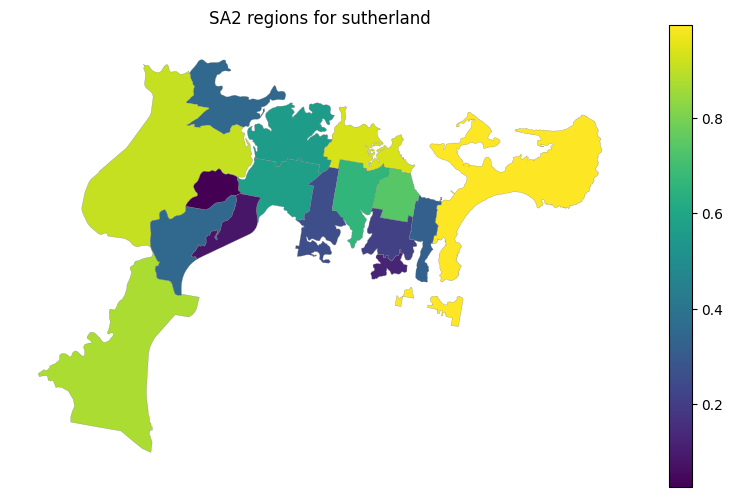

In [140]:
import matplotlib.pyplot as plt

gdf = gpd.read_postgis(
    '''
    SELECT sa2_name21, 
        geometry AS geom, 
        logistic_score 
    
    FROM sutherland_table
        JOIN sa2_sydney using (sa2_name21)''',
    conn,
    geom_col="geom",
    crs=4283
)

#  Plot a choropleth by the 'logistic_score' column:
ax = gdf.plot(
    column="logistic_score", 
    cmap="viridis",            
    legend=True,              
    figsize=(10, 6),
    edgecolor="0.5",      
    linewidth=0.2
)

ax.set_axis_off()
ax.set_title("SA2 regions for sutherland", pad=12)
plt.show()

In [141]:
#Create ryde table using sql
sql = get_table('Sydney - Ryde', "ryde")
query(conn, sql)

sql = '''
SELECT *
FROM ryde_table ry;
'''
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_name21,school_z_score,stop_z_score,z_score_businesses,z_score_pois,x,logistic_score
0,Hunters Hill - Woolwich,0.314070,-0.023218,1.506601,2.162914,3.960367,0.981300
1,Macquarie Park - Marsfield,2.032475,1.471593,-0.216723,0.588747,3.876091,0.979689
2,Pennant Hills - Cheltenham,1.842532,0.939785,-0.470851,0.869202,3.180668,0.960100
3,Gladesville - Huntleys Point,-0.229394,-0.253189,1.199444,1.357736,2.074597,0.888410
4,North Ryde - East Ryde,0.587201,0.738560,0.058229,0.172588,1.556577,0.825862
5,Eastwood,-0.235940,1.054770,0.680661,-0.406416,1.093074,0.748960
6,Ryde - North,-0.457931,1.069144,-0.839334,-0.071680,-0.299801,0.425606
7,Putney,0.078421,-1.460536,1.864044,-1.030655,-0.548726,0.366160
8,West Ryde - Meadowbank,-0.573603,0.120514,-0.412217,-0.144055,-1.009361,0.267105
9,Epping (NSW) - West,-1.064626,-0.166950,-0.330107,-0.967326,-2.529010,0.073849


In [142]:
# Hypothesis testing

sql = """
SELECT sa2_name, median_income, logistic_score
FROM ryde_table AS c
JOIN income AS i
  ON c.sa2_name21 = i.sa2_name;
"""
df = pd.read_sql(sql, conn)

r = df['logistic_score'].corr(df['median_income'])
print("Pearson r =", r)

Pearson r = 0.330549975656348


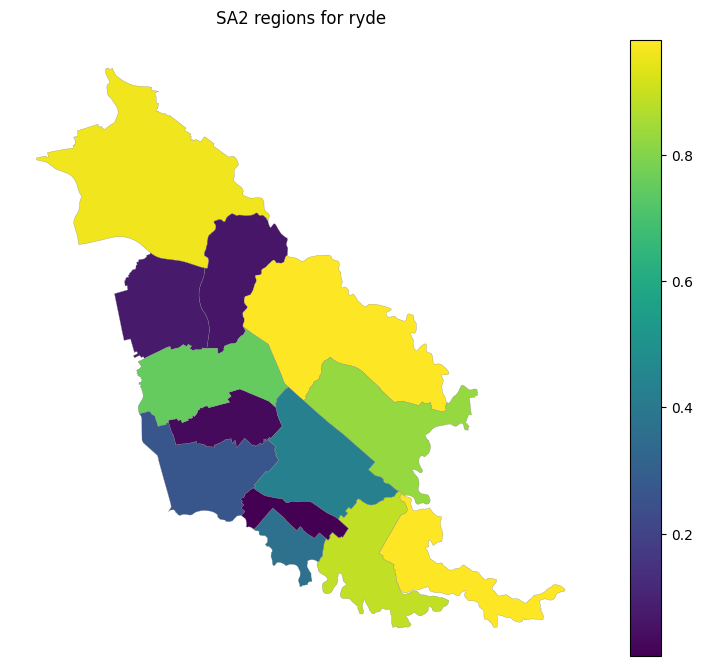

In [143]:
gdf = gpd.read_postgis(
    '''SELECT sa2_name21, 
    geometry AS geom, 
    logistic_score 
    
    FROM ryde_table su
        JOIN sa2_sydney sa using (sa2_name21)''',
    conn,
    geom_col="geom",    
    crs=4283
)

ax = gdf.plot(
    column="logistic_score",  
    cmap="viridis",            
    legend=True,               
    figsize=(10, 8),
    edgecolor="0.5",        
    linewidth=0.2
)

ax.set_axis_off()
ax.set_title("SA2 regions for ryde", pad=12)
plt.show()

In [144]:
#Create central_coast table using sql
sql = get_table('Central Coast', "central_coast")
query(conn, sql)


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [145]:
sql = '''
SELECT *
FROM central_coast_table
'''
query(conn, sql)

,sa2_name21,school_z_score,stop_z_score,z_score_businesses,z_score_pois,x,logistic_score
0,Calga - Kulnura,4.819800,-0.308218,3.704230,4.204269,12.420080,0.999996
1,Jilliby - Yarramalong,2.172393,0.385273,0.796835,2.097493,5.451994,0.995731
2,Gosford - Springfield,-0.283631,1.806931,0.685837,0.773535,2.982671,0.951785
3,Erina - Green Point,-0.240832,0.997857,0.908238,0.852342,2.517605,0.925367
4,Tuggerah - Kangy Angy,-0.183968,-0.319777,2.381606,-0.250957,1.626904,0.835745
5,Umina - Booker Bay - Patonga,-0.278016,2.165235,-0.512883,-0.140627,1.233709,0.774467
6,Woy Woy - Blackwall,-0.270119,1.229021,-0.596870,0.773535,1.135567,0.756865
7,Box Head - MacMasters Beach,-0.225240,0.177226,0.172554,0.416276,0.540816,0.632002
8,Warnervale - Wadalba,-0.265605,1.194347,-0.670181,0.269170,0.527729,0.628953
9,Chittaway Bay - Tumbi Umbi,-0.270338,1.286812,-0.147849,-0.445347,0.423278,0.604267


In [146]:
# Hypothesis testing

sql = """
SELECT sa2_name, median_income, logistic_score
FROM central_coast_table AS c
JOIN income AS i
  ON c.sa2_name21 = i.sa2_name;
"""
df = pd.read_sql(sql, conn)

r = df['logistic_score'].corr(df['median_income'])
print("Pearson r =", r)

Pearson r = -0.12908400311592108


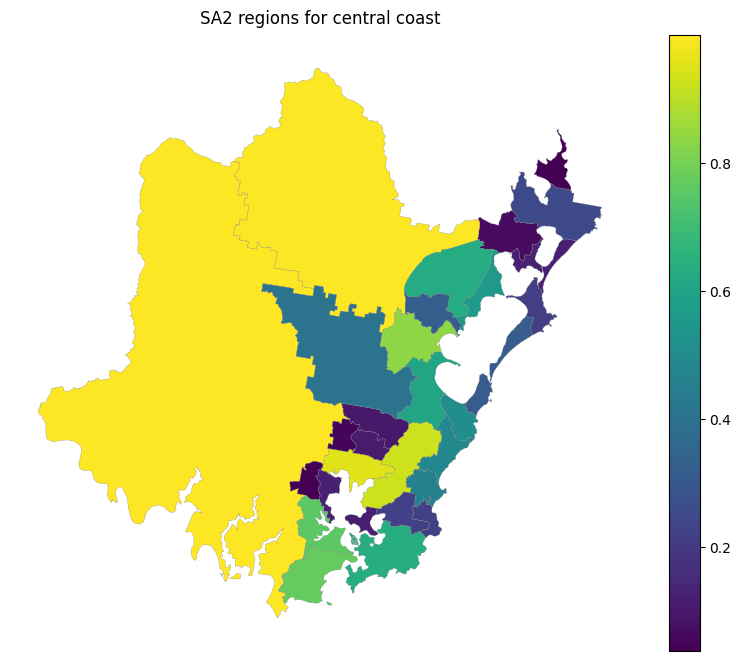

In [147]:
gdf = gpd.read_postgis(
    '''SELECT sa2_name21, 
    geometry AS geom, 
    logistic_score 
    
    FROM central_coast_table su
        JOIN sa2_sydney sa using (sa2_name21)''',
    conn,
    geom_col="geom",    
    crs=4283
)

ax = gdf.plot(
    column="logistic_score",   
    cmap="viridis",            
    legend=True,               
    figsize=(10, 8),
    edgecolor="0.5",    
    linewidth=0.2
)

ax.set_axis_off()
ax.set_title("SA2 regions for central coast", pad=12)
plt.show()

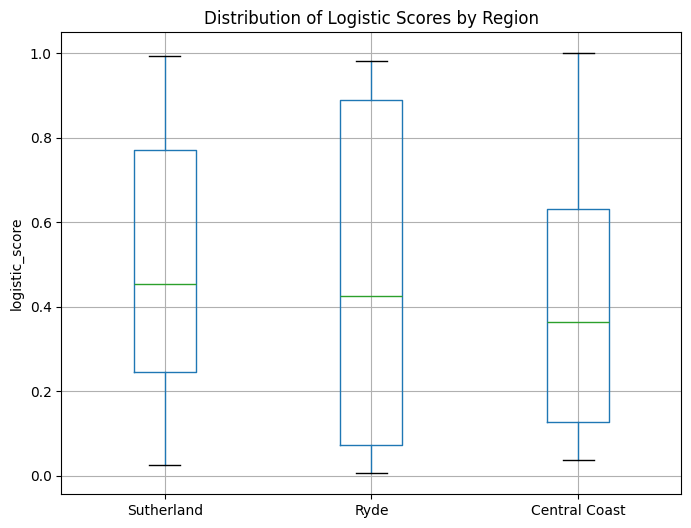

In [148]:
# boxplot
import pandas as pd
import matplotlib.pyplot as plt

suth = pd.read_sql("SELECT logistic_score FROM sutherland_table", conn)
ryde = pd.read_sql("SELECT logistic_score FROM ryde_table", conn)
central = pd.read_sql("SELECT logistic_score FROM central_coast_table", conn)


df = pd.DataFrame({
    'Sutherland':     suth['logistic_score'],
    'Ryde':           ryde['logistic_score'],
    'Central Coast':  central['logistic_score']
})


plt.figure(figsize=(8, 6))
df.boxplot()
plt.title("Distribution of Logistic Scores by Region")
plt.ylabel("logistic_score")
plt.show()


In [149]:

conn.close()
db.dispose()
